# Setup & Import the data

In [1]:
import os
import numpy as np
import pandas as pd

print(os.listdir("./"))
test_set = pd.read_csv("./input/test.tsv", sep = '\t')
train_set = pd.read_csv("./input/train.tsv", sep = '\t')

train_set['Sentiment'] = train_set['Sentiment'].apply(str)

['models', 'input', 'kaggleCompetition.ipynb', '.ipynb_checkpoints', 'output']


In [2]:
train_set.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [3]:
test_set.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


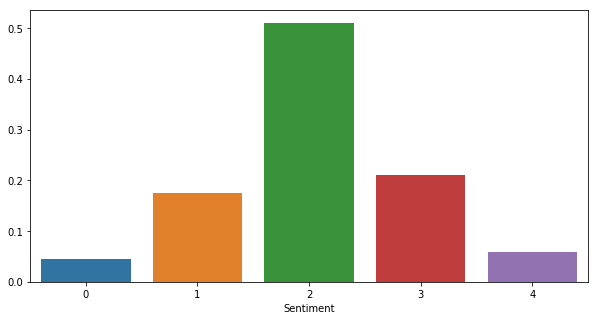

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from fastai.text import *

# Calculate how many reviews are by sentiment
distribution = train_set.groupby(["Sentiment"]).size()
# print(distribution, distribution.sum())

# Normalize everything to 1
distribution = distribution / distribution.sum()

plt.subplots(figsize = (10, 5))
sns.barplot(distribution.keys(), distribution.values)

# Creating Datasets for Language Model and FastAI data bunch

In [6]:
# 1. from_df -> Select the input
# 2. split_by_rand_pct -> Split the data between the training and the validation set
# 3. label_for_lm -> Label it for a language model
# 4. Databunch -> Finally we convert to a DataBunch

# Language model data
data_textList = (TextList.from_df(train_set, cols = 'Phrase')
                .split_by_rand_pct(0.2)
                .label_for_lm()
                .databunch())
data_textList.show_batch()

idx,text
0,goose xxbos of xxbos escapades demonstrating the adage that what is good for the goose xxbos escapades xxbos demonstrating the adage that what is good for the goose xxbos demonstrating the adage xxbos demonstrating xxbos the adage xxbos the xxbos adage xxbos that xxbos what is good for the goose xxbos what xxbos is xxbos good for the goose xxbos good xxbos for xxbos the goose xxbos goose xxbos is
1,"years of xxmaj russian history and culture compressed into an evanescent , seamless and sumptuous stream of consciousness . xxbos 300 years of xxmaj russian history and culture xxbos 300 years xxbos 300 xxbos years xxbos of xxmaj russian history and culture xxbos xxmaj russian history and culture xxbos xxmaj russian xxbos history and culture xxbos history and xxbos culture xxbos compressed into an evanescent , seamless and sumptuous stream"
2,"of one man 's quest to be president , but of how that man single - handedly turned a plane full of hard - bitten , cynical journalists into what was essentially , by campaign 's end , an extended publicity department xxbos quest to be president xxbos quest xxbos to be president xxbos be president xxbos president xxbos , but of how that man single - handedly turned a"
3,"when sitting around a campfire around midnight , telling creepy stories to give each other the willies . xxbos xxmaj frailty xxbos '' offers chills much like those that you get when sitting around a campfire around midnight , telling creepy stories to give each other the willies . xxbos offers chills much like those that you get when sitting around a campfire around midnight , telling creepy stories to"
4,"to be revealed by the dispassionate xxmaj gantz brothers as ordinary , pasty lumpen xxbos 's both degrading and strangely liberating xxbos both degrading and strangely liberating xxbos degrading and strangely liberating xxbos degrading and xxbos degrading xxbos strangely liberating xxbos liberating xxbos see people working so hard at leading lives of sexy intrigue , only to be revealed by the dispassionate xxmaj gantz brothers as ordinary , pasty lumpen"


In [7]:
# Classifier model data
test_textList = TextList.from_df(test_set, cols ='Phrase', vocab = data_textList.vocab)

data_classification = (TextList.from_df(train_set, cols = 'Phrase', vocab = data_textList.vocab)
             .split_by_rand_pct(0.2)
             .label_from_df(cols = 'Sentiment')
             .add_test(test_textList)
             .databunch())

data_classification.show_batch()

text,target
"xxbos xxup -lrb- xxmaj city xxup -rrb- reminds us how realistically nuanced a xxmaj robert xxmaj de xxmaj niro performance can be when he is not more lucratively engaged in the shameless self - caricature of ` xxmaj analyze xxmaj this ' xxup -lrb- 1999 xxup -rrb- and ` xxmaj analyze xxmaj that , ' promised xxup -lrb- or threatened xxup -rrb- for later this year .",3
"xxbos helped give a spark to ` ` xxmaj chasing xxmaj amy '' and ` ` xxmaj changing xxmaj lanes '' falls flat as thinking man xxup cia agent xxmaj jack xxmaj ryan in this summer 's new action film , ` ` xxmaj the xxmaj sum of xxmaj all xxmaj fears",0
"xxbos xxmaj its and pieces of xxmaj the xxmaj hot xxmaj chick are so hilarious , and xxmaj schneider 's performance is so fine , it 's a real shame that so much of the movie -- again , as in xxmaj the xxmaj animal -- is a slapdash mess .",1
"xxbos a very familiar tale , one that 's been told by countless filmmakers about xxmaj italian - , xxmaj chinese - , xxmaj irish - , xxmaj latin - , xxmaj indian - , xxmaj russian - and other hyphenate xxmaj american young men struggling to balance conflicting cultural messages",2
"xxbos xxmaj director xxmaj george xxmaj hickenlooper has had some success with documentaries , but here his sense of story and his juvenile camera movements smack of a film school undergrad , and his maudlin ending might not have gotten him into film school in the first place .",1


# Create and Train the Language Model

In [8]:
learn_model = language_model_learner(data_textList, AWD_LSTM, drop_mult = 0.3)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02
Min loss divided by 10: 3.63E-02


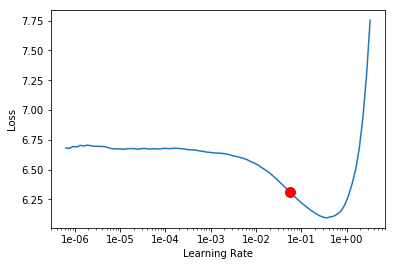

In [9]:
learn_model.lr_find()

learn_model.recorder.plot(suggestion=True)
# learn_model.recorder.plot()
# learn_model.recorder.plot_losses()
# learn_model.recorder.plot_lr()

In [10]:
learn_model.fit_one_cycle(10, slice(1e-2, (1e-2)*5), moms = (0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.191298,3.802963,0.350715,00:29
1,3.519883,3.326443,0.409706,00:29
2,3.404361,3.190566,0.433388,00:29
3,3.213739,3.000450,0.464080,00:30
4,3.022926,2.822673,0.493265,00:30
5,2.810514,2.643091,0.525066,00:30
6,2.595383,2.480656,0.554060,00:30
7,2.438550,2.369915,0.575279,00:31
8,2.292259,2.312697,0.584814,00:31
9,2.220126,2.304527,0.586816,00:30


In [11]:
# unfreeze the last 2 layers and train it a little bit more
learn_model.freeze_to(-2)
learn_model.fit_one_cycle(10, slice(1e-2, (1e-2)*5), moms = (0.8,0.7))
learn_model.save_encoder('encoder')

epoch,train_loss,valid_loss,accuracy,time
0,2.307488,2.327733,0.575813,00:31
1,2.651260,2.596194,0.520860,00:30
2,2.959773,2.762081,0.493342,00:31
3,2.893492,2.671955,0.508405,00:31
4,2.713310,2.501677,0.537776,00:31
5,2.455524,2.307618,0.573678,00:31
6,2.206615,2.134476,0.608820,00:31
7,2.009156,2.019787,0.633294,00:31
8,1.870627,1.966095,0.644249,00:31
9,1.796426,1.960179,0.646230,00:31


<!-- ## Creating the Classifier Model -->

# Using the Language Model to Train the Classifier

In [12]:
# Using text_classifier learner, we create the model which can predict the sentiment score
learn_classifier = text_classifier_learner(data_classification, AWD_LSTM, drop_mult = 0.3)
learn_classifier.load_encoder('encoder')
# The optimal learning rate can be found using
learn_classifier.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.09E-01
Min loss divided by 10: 3.63E-02


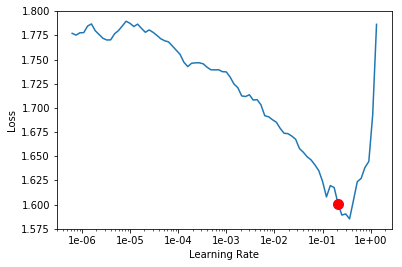

In [13]:
learn_classifier.recorder.plot(suggestion=True)
# learn_classifier.recorder.plot()
# learn_model.recorder.plot_losses()
# learn_model.recorder.plot_lr()

In [14]:
# We can create the final layers which predict the classifier tag, by training the model using
learn_classifier.fit_one_cycle(10, 1e-2, moms = (0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.175001,1.076182,0.564815,00:28
1,1.123269,1.065620,0.564334,00:27
2,1.133677,1.067044,0.563405,00:28
3,1.098858,1.062835,0.565424,00:27
4,1.109483,1.056703,0.570742,00:28
5,1.114763,1.040096,0.580706,00:28
6,1.099953,1.033443,0.582564,00:27
7,1.093858,1.023922,0.583718,00:28
8,1.103938,1.025635,0.587242,00:27
9,1.090653,1.025563,0.586057,00:28


In [15]:
learn_classifier.freeze_to(-2)
learn_classifier.fit_one_cycle(10, 1e-2, moms = (0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.029519,0.974825,0.602461,00:33
1,1.038961,0.929269,0.626714,00:34
2,0.974300,0.920453,0.624856,00:32
3,0.994641,0.888162,0.641132,00:33
4,0.925183,0.860839,0.649013,00:32
5,0.930787,0.873351,0.642702,00:32
6,0.842911,0.831352,0.663174,00:34
7,0.853503,0.823088,0.666378,00:33
8,0.782528,0.830900,0.668941,00:34
9,0.753619,0.840825,0.667275,00:31


In [16]:
learn_classifier.show_results()

text,target,prediction
"xxbos reminds us how realistically nuanced a xxmaj robert xxmaj de xxmaj niro performance can be when he is not more lucratively engaged in the shameless self - caricature of ` xxmaj analyze xxmaj this ' xxup -lrb- 1999 xxup -rrb- and ` xxmaj analyze xxmaj that , ' promised xxup -lrb- or threatened xxup -rrb- for later this year .",2,3
"xxbos xxmaj it may not be as cutting , as witty or as true as back in the glory days of xxmaj weekend and xxmaj two or xxmaj three xxmaj things i xxmaj know xxmaj about xxmaj her , but who else engaged in filmmaking today is so cognizant of the cultural and moral issues involved in the process ?",2,2
"xxbos xxmaj if xxmaj oscar had a category called xxmaj best xxmaj bad xxmaj film xxmaj you xxmaj thought xxmaj was xxmaj going xxmaj to xxmaj be xxmaj really xxmaj awful xxmaj but xxmaj was n't , xxmaj guys would probably be duking it out with xxmaj the xxmaj queen of the xxmaj damned for the honor .",1,2
"xxbos realistically nuanced a xxmaj robert xxmaj de xxmaj niro performance can be when he is not more lucratively engaged in the shameless self - caricature of ` xxmaj analyze xxmaj this ' xxup -lrb- 1999 xxup -rrb- and ` xxmaj analyze xxmaj that , ' promised xxup -lrb- or threatened xxup -rrb- for later this year",1,2
"xxbos xxmaj the 70-year - old xxmaj godard has become , to judge from xxmaj in xxmaj praise of xxmaj love , the sort of bitter old crank who sits behind his light meter and harangues the supposed injustices of the artistic world - at - large without doing all that much to correct them .",2,1


# Analyzing our results

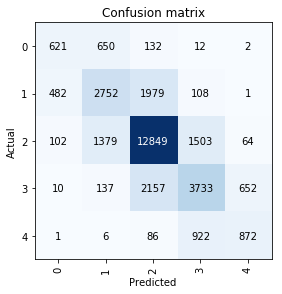

In [17]:
# preds, y, losses = learn_classifier.get_preds(DatasetType.Test, with_loss=True, ordered = True)
preds, y, losses = learn_classifier.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn_classifier, preds, y, losses)
interp.plot_confusion_matrix()

# Export the model

In [18]:
preds, target = learn_classifier.get_preds(DatasetType.Test, ordered = True)
labels = np.argmax(preds, axis =1)
submission = pd.DataFrame({'PhraseId': test_set['PhraseId'], 'Sentiment': labels, 'Text': test_set['Phrase']})
submission.to_csv('./output/submission.csv', index = False)